In [1]:
import polars as pl
import matplotlib.pyplot as plt
from event_detection_ap_score import event_detection_ap

import pandas as pd

In [2]:
# BASE_PATH = '/home/matmozaur/Downloads/child-mind-institute-detect-sleep-states/'
BASE_PATH = '../../cmidss/'

In [3]:
x_train = pl.read_parquet(BASE_PATH+'train_series.parquet')
y_train = pl.read_csv(BASE_PATH+'train_events.csv')

In [95]:
s_idxs = list(y_train['series_id'].unique())

In [149]:
y = y_train.filter(pl.col("series_id").is_in(s_idxs[10:20])).to_pandas()

x = x_train.filter(pl.col("series_id").is_in(s_idxs[10:20])).to_pandas()

In [150]:
y = y.dropna()

In [151]:
x['timestamp'] = pd.to_datetime(x['timestamp'].apply(lambda x: x[:19]))
y['timestamp'] = pd.to_datetime(y['timestamp'].apply(lambda x: x[:19]))
x.set_index('timestamp', inplace=True)
y.set_index('timestamp', inplace=True)

In [152]:
x.sort_index(inplace=True)
y.sort_index(inplace=True)

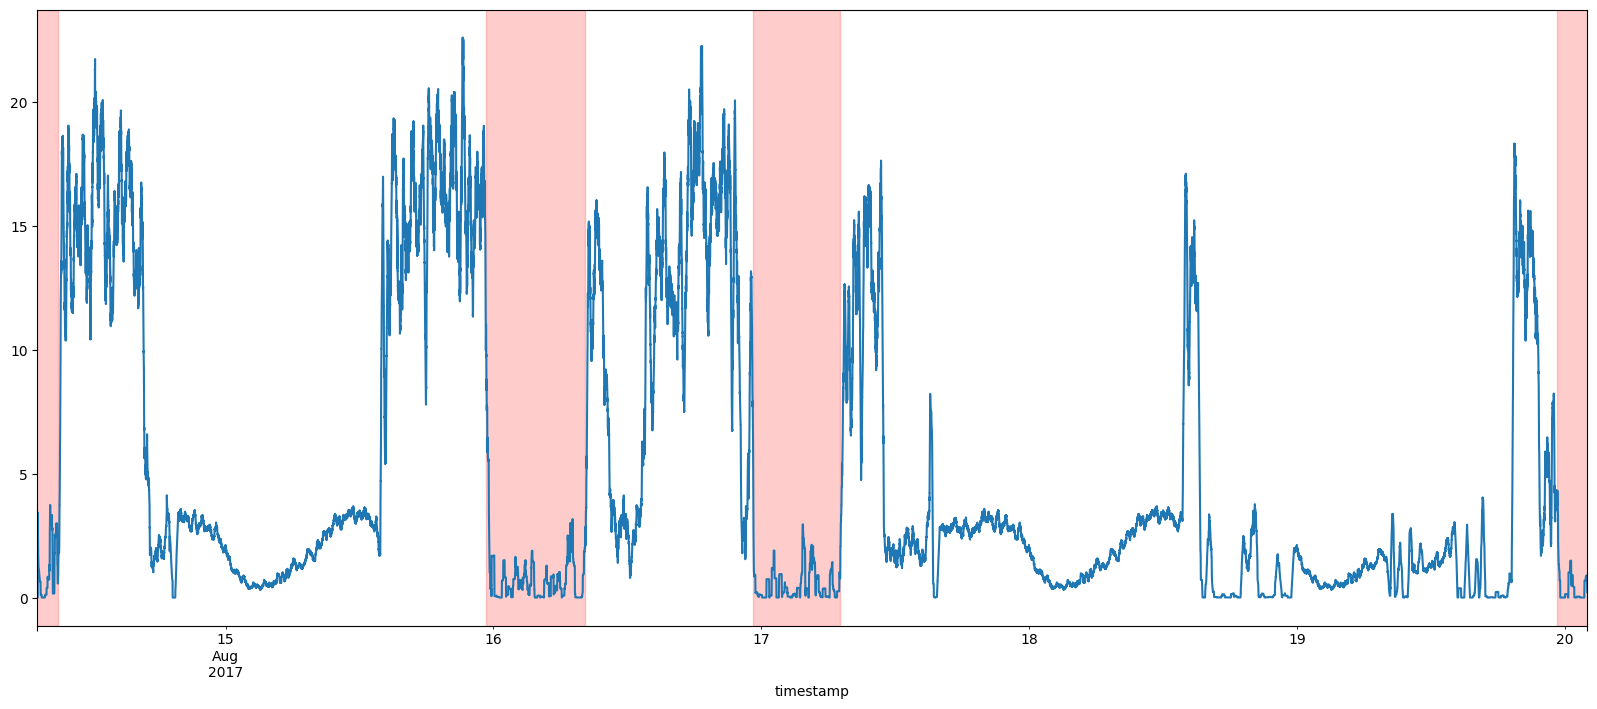

In [153]:
x['anglez'][100000:200000].diff().abs().rolling('15min').mean().plot(figsize=(20,8))
for a, b in zip(y[y['event']=='onset'].index, y[y['event']=='wakeup'].index):
    plt.axvspan(a, b,alpha=0.2, color='r')

In [217]:
t = x[:100000]['anglez'].diff().abs().rolling('15min').mean() < 1

t = t.rolling('60min').max()
t = t[::-1].rolling('60min').min()[::-1]

t = t.rolling('60min').min()
t = t[::-1].rolling('60min').max()[::-1]

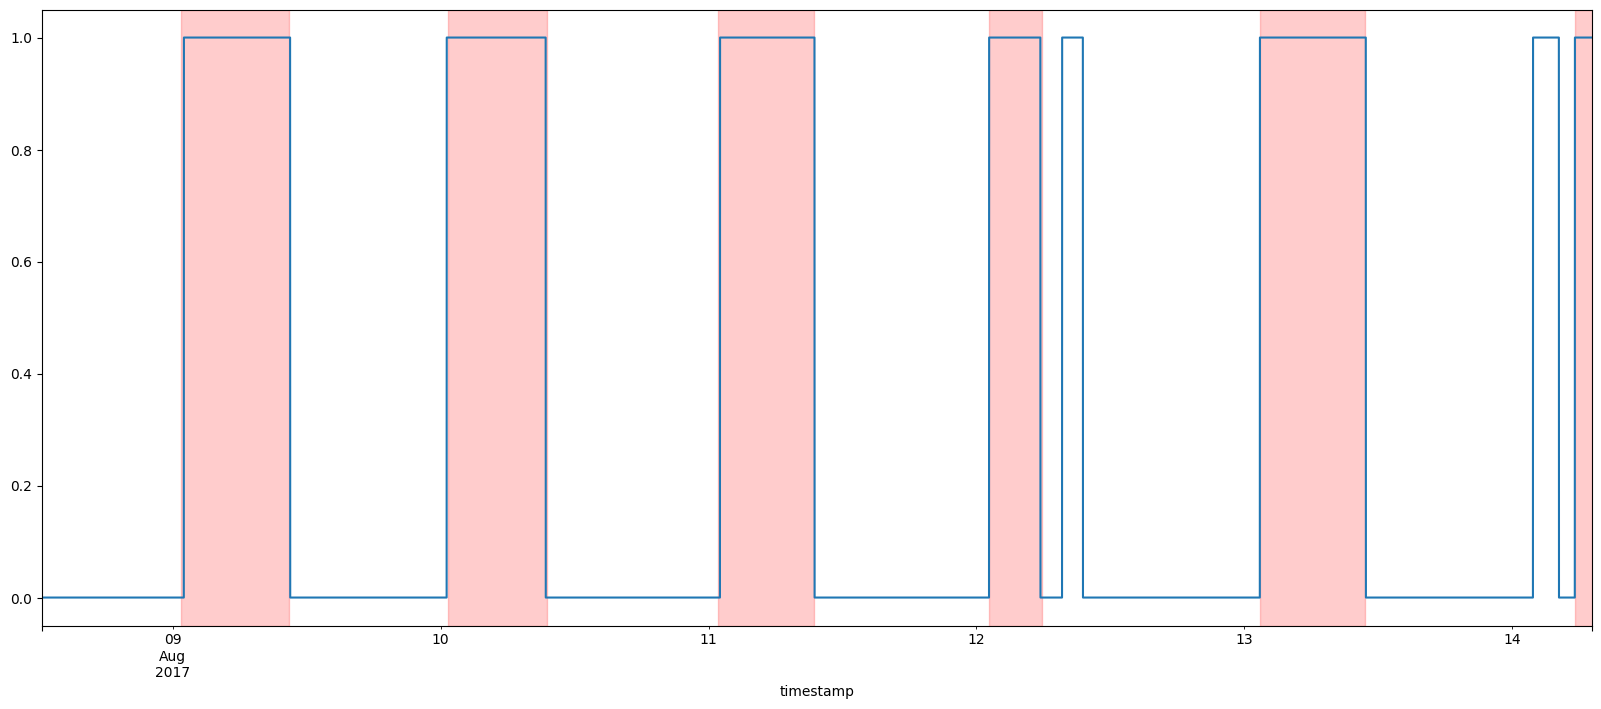

In [218]:
t.astype(int).plot(figsize=(20,8))
for a, b in zip(y[y['event']=='onset'].index, y[y['event']=='wakeup'].index):
    plt.axvspan(a, b,alpha=0.2, color='r')

In [160]:
# t[t.diff()==1]

In [237]:
(y['step'][:60].diff()[1::2]/12/60).min()

3.3833333333333333

In [212]:
# y[y['event'] == 'onset'][:50]

In [248]:
# t = x['anglez'].diff().abs().rolling('15min').mean() < 3

t = x['anglez'].diff().abs().rolling('15min').mean() < 2
t = t.rolling('45min').max()
t = t[::-1].rolling('45min').min()[::-1]

t = t.rolling('60min').min()
t = t[::-1].rolling('60min').max()[::-1]

t2 = t.astype(int).diff()[2:]
t2 = t2[t2[t2==1].index[0]:]

In [249]:
# for a, b in zip(t2[t2==1].index, t2[t2==-1].index):
#     if a.hour in list(range(18, 25)) + list(range(0, 2)):
#         print(a, b)

In [250]:
last = t2.index[0] - pd.Timedelta('24h')
rows = []
i = 0 
for a in t2[t2==1].index:
    if a.hour in list(range(19, 25)) + list(range(0, 3)) and a > last + pd.Timedelta('10h'):
        try:
            b = t2[a+pd.Timedelta('3h'):a+pd.Timedelta('12h')][t2[a+pd.Timedelta('3h'):a+pd.Timedelta('12h')]==-1].index[0]
            last = a
            d1 = x.loc[a][['series_id', 'step']].to_dict()
#             d1['step'] -= 70
            i += 1
            d1['event'] = 'onset'
            d1['score'] = 1
            rows.append(d1)
            d2 = x.loc[b][['series_id', 'step']].to_dict()
#             d2['step'] -= 50
            i += 1
            d2['event'] = 'wakeup'
            d2['score'] = 1
            rows.append(d2)
        except:
            print(a)
            continue
        

res = pd.DataFrame.from_records(rows)

2017-08-31 20:36:15
2017-09-02 21:27:25
2017-12-21 22:07:55
2017-12-28 23:44:10
2018-01-04 23:15:30
2018-01-11 20:55:25
2018-03-27 20:30:55
2018-03-28 20:28:10
2018-08-25 23:27:40
2019-01-08 19:36:00
2019-04-15 22:16:25


In [251]:
y_res = y[["series_id","step","event"]].copy()

y_res['score'] = 1

y_res = y_res.reset_index()[['series_id', 'step', 'event', 'score']]

In [252]:
(res['step'] - y_res['step'])[:12]

0      153.0
1       87.0
2      -98.0
3      -32.0
4      105.0
5       55.0
6     -132.0
7      430.0
8      -64.0
9       59.0
10   -2859.0
11      67.0
Name: step, dtype: float64

In [253]:
res

,series_id,step,event,score
0,ece2561f07e9,9129,onset,1
1,ece2561f07e9,16059,wakeup,1
2,ece2561f07e9,26110,onset,1
3,ece2561f07e9,32536,wakeup,1
4,ece2561f07e9,43725,onset,1
...,...,...,...,...
289,83fa182bec3a,151805,wakeup,1
290,83fa182bec3a,163178,onset,1
291,83fa182bec3a,169144,wakeup,1
292,83fa182bec3a,179888,onset,1


In [254]:
event_detection_ap(res, y_res, T)

0.16829024943310658

In [255]:
x.columns

Index(['series_id', 'step', 'anglez', 'enmo'], dtype='object')

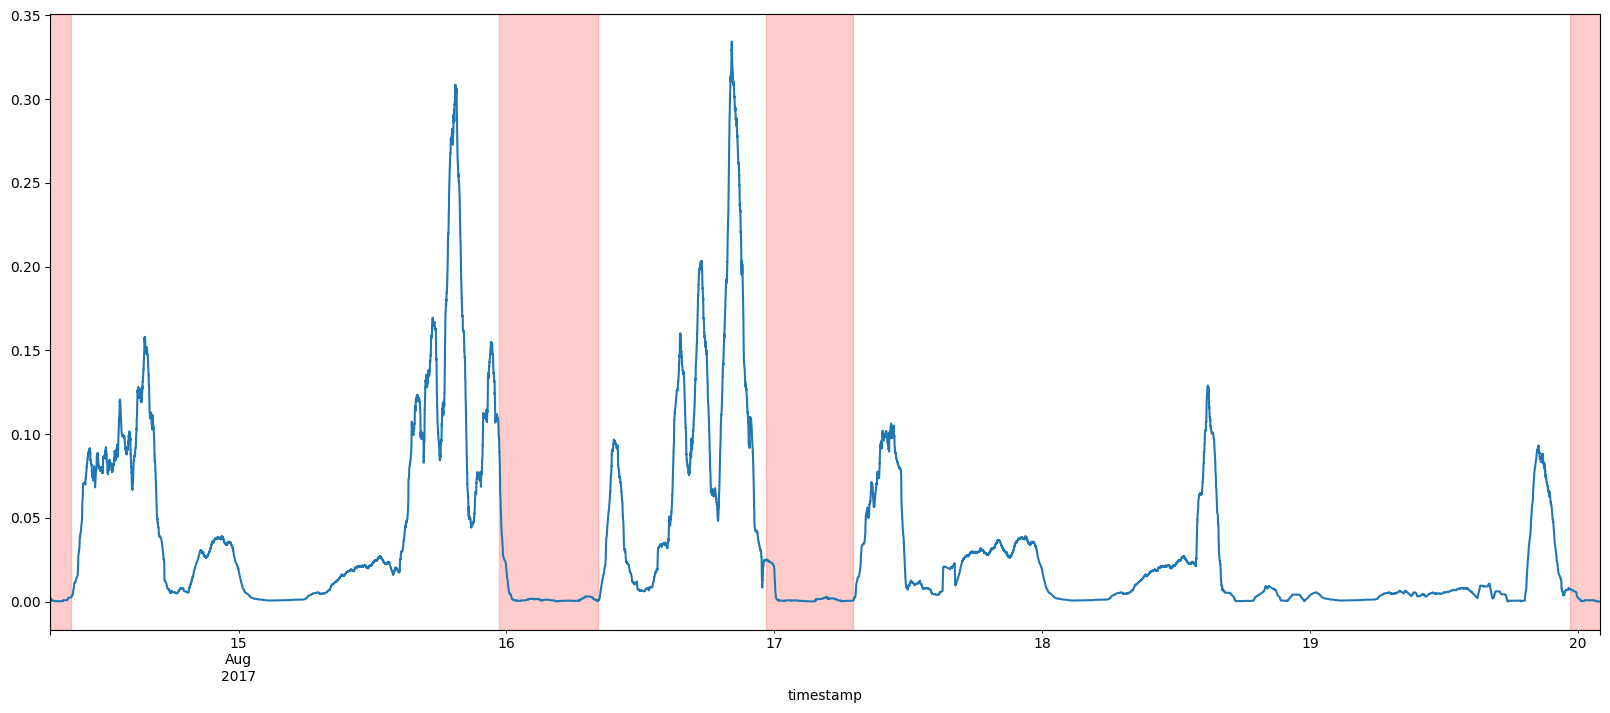

In [259]:
x['enmo'][100000:200000].diff().abs().rolling('65min').mean().plot(figsize=(20,8))
for a, b in zip(y[y['event']=='onset'].index, y[y['event']=='wakeup'].index):
    plt.axvspan(a, b,alpha=0.2, color='r')